# Decoded Quantum Interferometry Algorithm

This notebook relates to the paper "Optimization by Decoded Quantum Interferometry" (DQI) [[1](#DQI)], which introduces a quantum algorithm for combinatorial optimization problems.

The algorithm focuses on finding approximate solutions to the *max-LINSAT* problem, and takes advantage of the sparse Fourier spectrum of certain optimization functions.

## max-LINSAT Problem
* **Input:**  A matrix $B \in \mathbb{F}^{m \times n}$ and $m$ functions $f_i : \mathbb{F} \rightarrow \{+1, -1\}$ for $i = 1, \cdots, m $, where $\mathbb{F}$ is a finite field.

  Define the objective function $f : \mathbb{F}^n \rightarrow \mathbb{Z}$  to be $f(x) = \sum_{i=1}^m f_i \left( \sum_{j=1}^n B_{ij} x_j \right)$. 

* **Output:** a vector $x \in \mathbb{F}^n$ that best maximizes $f$.

The paper shows that for the problem of *Optimal Polynomial Intersection (OPI)*—a special case of the the *max-LINSAT*—the algorithm can reach a better approximation ratio than any known polynomial time classical algorithm.

We demonstrate the algorithm in the setting of *max-XORSAT*, which is another special case of *max-LINSAT*, and is different from the *OPI* problem. Even though the paper does not show a quantum advantage with *max-XORSAT*, it is simpler to demonstrate.

## max-XORSAT Problem

* **Input:**  A matrix $B \in \mathbb{F}_2^{m \times n}$ and a vector $v \in \mathbb{F}_2^m$ with $m > n$.

  Define the objective function $f : \mathbb{F}_2^n \rightarrow \mathbb{Z}$  as $f(x) = \sum_{i=1}^m (-1)^{v_i + b_i \cdot x} = \sum_{i=1}^m f_i(x)$ (with $b_i$ the columns of $B$),  which represents the number of satisfied constraints minus the number of unsatisfied constraints for the equation $Bx=v$. 

* **Output:** a vector $x \in \mathbb{F}_2^n$ that best maximizes $f$.


The *max-XORSAT* problem is NP-hard. As an example, the *Max-Cut* problem is a special case of *max-XORSAT* where the number of ones in each row is exactly two. The DQI algorithm focuses on finding approximate solutions to the problem. 

## Algorithm Description
The strategy is to prepare this state:
$$
|P(f)\rangle = \sum_{x\in\mathbb{F}_2^n}P(f(x))|x\rangle
$$

where $P$ is a normalized polynomial. Choosing a good polynomial can bias the sampling of the state towards high $f$ values. The higher the degree $l$ of the polynomial, the better approximation ratio of the optimum we can get. The Hadamard spectrum of $|P(f)\rangle$ is
$$
\sum_{k = 0}^{l} \frac{w_k}{\sqrt{\binom{m}{k}}}
\sum_{\substack{y \in \mathbb{F}_2^m \\ |y| = k}} (-1)^{v \cdot y} |B^T y\rangle
$$
where $w_k$ are normalized weights that can be calculated from the coefficients of $P$. So, to prepare $|P(f)\rangle$, we prepare its Hadamard transform, then apply the Hadamard transform over it. 

Stages:

1. Prepare $\sum_{k=0}^l w_k|k\rangle$.

2. Translate the binary encoded $|k\rangle$ to a unary encoded state $|k\rangle_{unary} = |\underbrace{1 \cdots 1}_{k}   \underbrace{0 \cdots 0}_{n - k} \rangle$, resulting in the state $\sum_{k=0}^l w_k|k\rangle_{unary}$.

3. Translate each $|k\rangle_{unary}$ to a Dicke state [[2](#Dicke)], resulting in the state $\sum_{k = 0}^{l} \frac{w_k}{\sqrt{\binom{m}{k}}}
\sum_{\substack{y \in \mathbb{F}_2^m \\ |y| = k}} |y\rangle_m$.

4. For each $|y\rangle_m$, calculate $(-1)^{v \cdot y} |y\rangle_m |B^T y\rangle_n$, getting $\sum_{k = 0}^{l} \frac{w_k}{\sqrt{\binom{m}{k}}}
\sum_{\substack{y \in \mathbb{F}_2^m \\ |y| = k}} (-1)^{v \cdot y} |y\rangle_m |B^T y\rangle_n$.

5. Uncompute $|y\rangle_m$ by decoding  $|B^T y\rangle_n$.

6. Apply the Hadamard transform to get the desired $|P(f)\rangle$.



Step 5 is the heart of the algorithm. The decoding of $|B^T y\rangle_n$ is, in general, an ill-defined problem, but when the hamming weight of $y$ is known to be limited by some integer l (the degree of $P$) , it might be feasible and even efficient, depending on the structure of the matrix $B$. The problem is equivalent to the decoding error from syndrome [[3](#SYND)], where $B^T$ is the parity-check matrix.

Figure 1 shows a layout of the resulting quantum program. Executing the quantum program guarantees that we sample `x` with high $f$ values with high probability (see the last plot in this notebook).

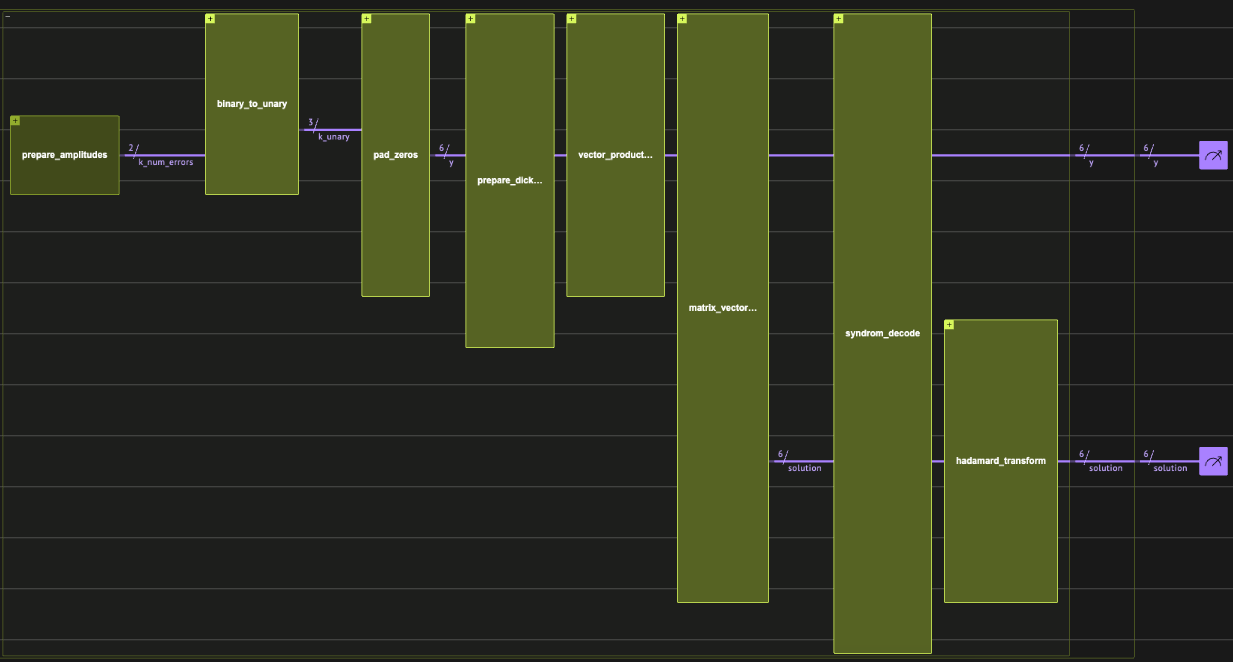
<figcaption align = "middle"> Figure 1. The full DQI circuit for a *MaxCut* problem. The `x` solutions are sampled from the `target` variable after the last Hadamard transform.</figcaption>
</center>

## Defining the Algorithm Building Blocks

Next, we define the needed building-blocks for all algorithm stages. Step 1 is omitted as we use the built-in `prepare_amplitudes` function.

### Step 2: Encoding Conversions

We use three different encodings:
- **Binary encoding**: Represents a number using binary bits, where each qubit corresponds to a binary place value. For example, the number 3 on 4 qubits is $|1100\rangle$.
- **One-hot encoding**: Represents a number by activating a single qubit, with its position indicating the value. For example, the number 3 on 4 qubits is $|0001\rangle$.
- **Unary encoding**: Represents a number by setting the first $k$ qubits to 1 $k$ is the number, and the rest to 0. For example, the number 3 on 4 qubits is $|1110\rangle$.

Specifically, we translate a binary (unsigned `QNum`) to one-hot encoding, and show how to convert the one-hot encoding to a unary encoding.

The conversions are done in place, meaning that the same binary encoded quantum variable is extended to represent the target encoding.
The logic is based on [this post](https://quantumcomputing.stackexchange.com/questions/5526/garbage-free-reversible-binary-to-unary-decoder-construction).

In [1]:
import numpy as np

from classiq import *


def get_rewire_list(qvars):
    rewire_list = [qvar for qvar in qvars[int(np.log2(len(qvars))) :]]
    [
        rewire_list.insert(2 ** (i + 1) - 1, qvar)
        for i, qvar in enumerate(qvars[: int(np.log2(len(qvars)))])
    ]
    return rewire_list


@qfunc
def binary_to_one_hot(binary: Input[QNum], one_hot: Output[QArray]):
    extension = QArray()
    allocate(2**binary.size - binary.size, extension)
    bind([binary, extension], one_hot)

    inplace_binary_to_one_hot(one_hot)


@qfunc
def inplace_binary_to_one_hot(one_hot: QArray):
    temp_qvars = [QBit(f"temp_{i}") for i in range(one_hot.len)]
    bind(one_hot, temp_qvars)
    bind(get_rewire_list(temp_qvars), one_hot)

    # logic
    X(one_hot[0])
    for i in range(int(np.log2(one_hot.len))):
        index = 2 ** (i + 1) - 1
        for j in range(2**i - 1):
            control(one_hot[index], lambda: SWAP(one_hot[j], one_hot[j + 2**i]))
        for j in range(2**i - 1):
            CX(one_hot[j + 2**i], one_hot[index])

        CX(one_hot[index], one_hot[index - 2**i])


@qfunc
def inplace_one_hot_to_unary(qvar: QArray):
    # fill with 1s after the leading 1 bit
    repeat(qvar.len - 1, lambda i: CX(qvar[qvar.len - i - 1], qvar[qvar.len - i - 2]))
    # clear the 0 bit
    X(qvar[0])


@qfunc
def one_hot_to_unary(one_hot: Input[QArray], unary: Output[QArray]):
    inplace_one_hot_to_unary(one_hot)
    lsb = QBit()
    bind(one_hot, [lsb, unary])
    free(lsb)


@qfunc
def binary_to_unary(binary: Input[QNum], unary: Output[QArray]):
    one_hot = QArray()
    binary_to_one_hot(binary, one_hot)
    one_hot_to_unary(one_hot, unary)

Now, we test the function on the conversion of the number 8 from binary to unary:

In [2]:
@qfunc
def main(one_hot: Output[QArray]):
    binary = QNum()
    binary |= 8
    binary_to_unary(binary, one_hot)


qprog_one_hot = synthesize(main)
res_one_hot = execute(qprog_one_hot).get_sample_result()
res_one_hot.parsed_counts

[{'one_hot': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}: 2048]

### Step 3: Dicke State Preparation

We transform a unary input quantum variable to a Dicke state, such that
$$
U|\underbrace{1 \cdots 1}_{k}   \underbrace{0 \cdots 0}_{n - k} \rangle = \sum_{k = 0}^{l} \frac{1}{\sqrt{\binom{n}{k}}}
\sum_{\substack{|y| = k}} |y\rangle_n
$$
This recursive implementation is based on [[2](#Dicke)]. The recursion works bit by bit.

In [3]:
from classiq.qmod.symbolic import acos, sqrt


@qfunc
def _dicke_split_cycle_shift(k: int, qvar: QArray):
    """
    internal function, assumes the input is in the form |11..100..0> with up to k ones.
    transforms the state to: sqrt(1/n)*|11..100..0> + sqrt((n-1)/n)*|01..110..0>.
    """
    for l in range(k):
        within_apply(
            lambda: CX(qvar[l + 1], qvar[0]),
            lambda: (
                control(
                    qvar[0], lambda: RY(2 * acos(sqrt((l + 1) / qvar.len)), qvar[l + 1])
                )
                if l == 0
                else control(
                    qvar[0] & qvar[l],
                    lambda: RY(2 * acos(sqrt((l + 1) / qvar.len)), qvar[l + 1]),
                )
            ),
        )


@qfunc
def prepare_dick_state_unary_input(max_k: int, qvar: QArray):
    """
    assumes the input is encoded in qvar in unary encoding. should work for every value
    smaller than max_k
    """
    if qvar.len > 1:
        _dicke_split_cycle_shift(max_k, qvar)
        prepare_dick_state_unary_input(min(max_k, qvar.len - 2), qvar[1 : qvar.len])


@qfunc
def prepare_dicke_state(k: int, qvar: QArray):
    apply_to_all(X, qvar[0:k])
    prepare_dick_state_unary_input(k, qvar)

We test the function for the Dicke state of six qubits with four ones:

In [4]:
@qfunc
def main(qvar: Output[QArray]):
    allocate(6, qvar)
    prepare_dicke_state(4, qvar)


qprog_dicke = synthesize(main)

In [5]:
res_dicke = execute(qprog_dicke).get_sample_result()
res_dicke.parsed_counts

[{'qvar': [1, 0, 1, 0, 1, 1]}: 159,
 {'qvar': [1, 1, 1, 0, 0, 1]}: 155,
 {'qvar': [0, 1, 1, 1, 0, 1]}: 147,
 {'qvar': [1, 0, 1, 1, 1, 0]}: 147,
 {'qvar': [0, 0, 1, 1, 1, 1]}: 147,
 {'qvar': [0, 1, 1, 0, 1, 1]}: 145,
 {'qvar': [0, 1, 1, 1, 1, 0]}: 142,
 {'qvar': [1, 1, 1, 0, 1, 0]}: 133,
 {'qvar': [1, 0, 1, 1, 0, 1]}: 131,
 {'qvar': [1, 1, 0, 0, 1, 1]}: 130,
 {'qvar': [1, 1, 0, 1, 0, 1]}: 129,
 {'qvar': [0, 1, 0, 1, 1, 1]}: 127,
 {'qvar': [1, 1, 0, 1, 1, 0]}: 125,
 {'qvar': [1, 0, 0, 1, 1, 1]}: 124,
 {'qvar': [1, 1, 1, 1, 0, 0]}: 107]

### Step 4: Vector and Matrix Products

In [6]:
from functools import reduce


@qfunc
def vector_product_phase(v: CArray[CInt], y: QArray):
    repeat(y.len, lambda i: if_(v[i] > 0, lambda: Z(y[i])))


@qfunc
def matrix_vector_product(B: list[list[int]], y: QArray, out: Output[QArray]):
    allocate(len(B), out)
    for i in range(len(B)):
        out[i] ^= reduce(
            lambda x, y: x ^ y, [int(B[i][j]) * y[j] for j in range(y.len)]
        )

## Assembling the Full max-XORSAT Algorithm

Here, we combine all the building blocks into the full algorithm. To save qubits, the decoding is done in place, directly onto the $|y\rangle$ register. The only remaining part is the decoding, that will be treated after choosing the problem to optimize, as it depends on the input structure.

`dqi_max_xor_sat` is the main quantum function of the algorithm. It expects the following arguments:
- `B`: the (classical) constraints matrix of the optimization problem
- `v`: the (classical) constraints vector of the optimization problem
- `w_k`: a (classical) vector of coefficients $w_k$ corresponding to the polynomial transformation of the target function. The index of the last non-zero element sets the maximum number of errors that the decoder should decode
- `y`: the (quantum) array of the errors for the decoder to decode. If the decoder is perfect, it should hold only zeros at the output
- `solution`: the (quantum) output array of the solution. It holds $|B^Ty\rangle$ before the Hadamard transform. 
- `syndrome_decode`: a quantum callable that accepts a syndrome quantum array and outputs the decoded error on its second quantum argument

In [7]:
@qfunc
def pad_zeros(total_size: int, qvar: Input[QArray], qvar_padded: Output[QArray]):
    """
    utility function for padding a quantum variable with 0's at its end. It is used for
    extending a unary encoded variable to be in the size of the optimization array.
    """
    extension = QArray()
    allocate(total_size - qvar.len, extension)
    bind([qvar, extension], qvar_padded)


@qfunc
def dqi_max_xor_sat(
    B: list[list[int]],
    v: list[int],
    w_k: list[float],
    y: Output[QArray],
    solution: Output[QArray],
    syndrom_decode: QCallable[QArray, QArray],
):
    k_num_errors = QNum()
    prepare_amplitudes(w_k, 0, k_num_errors)

    k_unary = QArray()
    binary_to_unary(k_num_errors, k_unary)

    # pad with 0's to the size of m
    pad_zeros(B.len, k_unary, y)

    # Create the Dicke states
    max_errors = int(np.nonzero(w_k)[0][-1]) if np.any(w_k) else 0
    prepare_dick_state_unary_input(max_errors, y)

    # Apply the phase
    vector_product_phase(v, y)

    # Compute |B^T*y> to a new register
    matrix_vector_product(np.array(B).T.tolist(), y, solution)

    # uncompute |y>
    # decode the syndrom inplace directly on y
    syndrom_decode(solution, y)

    # transform from Hadamard space to function space
    hadamard_transform(solution)

## Example Problem: Max-Cut for Regular Graphs

Now, let's be more specific and optimize a Max-Cut problem. We choose specific parameters so that with the resulting $B$ matrix we can decode up to two errors on the vector $|y\rangle$.

The translation between Max-Cut and max-XORSAT is quite straightforward. Every edge is a row, with the nodes as columns. The $v$ vector is all ones, so that if $(v_i, v_j) \in E$, we get a constraint $x_i \oplus x_j = 1$, which is satisfied if $x_i$, $x_j$ are on different sides of the cut.

B matrix:
 [[1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]


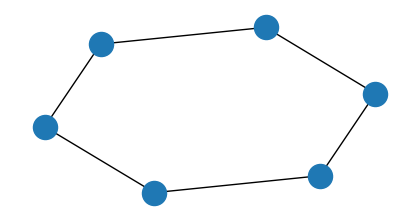

In [8]:
import itertools
import warnings

import matplotlib.pyplot as plt
import networkx as nx

warnings.filterwarnings("ignore", category=FutureWarning)


# A 2-regular graph on 6 nodes
G = nx.Graph()
G.add_nodes_from([3, 4, 1, 5, 2, 0])
G.add_edges_from([(3, 4), (3, 2), (4, 1), (1, 5), (5, 0), (2, 0)])

B = nx.incidence_matrix(G).T.toarray()
v = np.ones(B.shape[0])

plt.figure(figsize=(4, 2))
nx.draw(G)
print("B matrix:\n", B)

### Original Sampling Statistics

Let's plot the statistics of $f$ for uniformly sampling $x$, as a histogram. 

Later, we show how to get a better histogram after sampling from the state of the DQI algorithm.

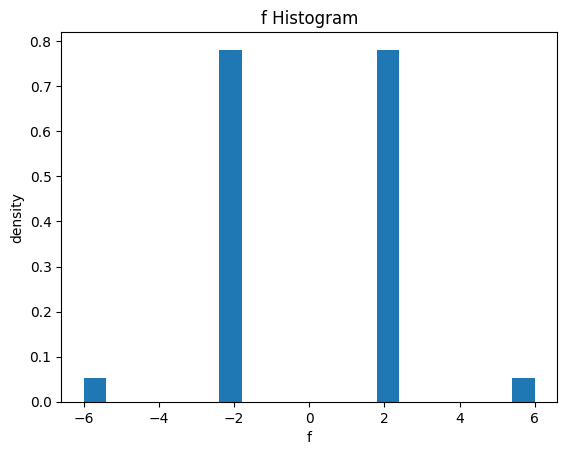

In [9]:
# plot f statistics
all_inputs = np.array(list(itertools.product([0, 1], repeat=B.shape[1]))).T
f = ((-1) ** (B @ all_inputs + v[:, np.newaxis])).sum(axis=0)

# plot a histogram of f
plt.hist(f, bins=20, density=True)
plt.xlabel("f")
plt.ylabel("density")
plt.title("f Histogram")
plt.show()

### Decodability of the Resulting Matrix

The transposed matrix of the specific matrix we have chosen can be decoded with up to two errors, which corresponds to a polynomial transformation of $f$ of degree 2 in the amplitude, and degree 4 in the sampling probability:

In [10]:
# set the code length and possible number of errors
MAX_ERRORS = 2  # l in the paper
n = B.shape[0]

# Generate all vectors in one line
errors = np.array(
    [
        np.array([1 if i in ones_positions else 0 for i in range(n)])
        for num_ones in range(MAX_ERRORS + 1)
        for ones_positions in itertools.combinations(range(n), num_ones)
    ]
)
syndromes = (B.T @ errors.T % 2).T

print("num errors:", errors.shape[0])
print("num syndromes:", len(set(tuple(x) for x in list((syndromes)))))
print("B shape:", B.shape)

num errors: 22
num syndromes: 22
B shape: (6, 6)


### Step 5: Defining the Decoder

For this basic demonstration, we use a brute force decoder that uses a lookup table for decoding each syndrome in superposition:

In [11]:
def _to_int(binary_array):
    return int("".join(str(int(bit)) for bit in reversed(binary_array)), 2)


@qfunc
def syndrome_decode_lookuptable(syndrome: QNum, error: QNum):
    for i in range(len(syndromes)):
        control(
            syndrome == _to_int(syndromes[i]),
            lambda: inplace_xor(_to_int(errors[i]), error),
        )

It is also possible to define a decoder that uses a local rule of syndrome majority.
This decoder can correct just one error.

In [12]:
@qfunc
def syndrome_decode_majority(syndrome: QArray, error: QArray):
    for i in range(B.shape[0]):
        # if 2 syndromes are 1, then the decoded bit will be 1, else 0
        synd_1 = np.nonzero(B[i])[0][0]
        synd_2 = np.nonzero(B[i])[0][1]
        error[i] ^= syndrome[synd_1] & syndrome[synd_2]

### Choosing Optimal $w_k$ Coefficients
According to the paper [[1](#DQI)], this is done by finding the principal value of a tridiagonal matrix $A$ defined by the following code. The optimality is with regard to the expected ratio of satisfied constraints.

In [13]:
def get_optimal_w(m, n, l):
    # max-xor sat:
    p = 2
    r = 1
    d = (p - 2 * r) / np.sqrt(r * (p - r))

    # Build A matrix
    diag = np.arange(l + 1) * d
    off_diag = [np.sqrt(i * (m - i + 1)) for i in range(l)]
    A = np.diag(diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)

    # get W_k as the principal vector of A
    eigenvalues, eigenvectors = np.linalg.eig(A)
    principal_vector = eigenvectors[:, np.argmax(eigenvalues)]

    # normalize
    return principal_vector / np.linalg.norm(principal_vector)


# normalize
W_k = get_optimal_w(m=B.shape[0], n=B.shape[1], l=MAX_ERRORS)

print("Optimal w_k vector:", W_k)
# complete W_k to a power of 2 for the usage in prepare_state
W_k = np.pad(W_k, (0, 2 ** int(np.ceil(np.log2(len(W_k)))) - len(W_k)))

Optimal w_k vector: [0.         0.70710678 0.70710678]


### Synthesis and Execution of the Full Algorithm

In [14]:
from classiq.execution import *


@qfunc
def main(y: Output[QArray], solution: Output[QArray]):
    dqi_max_xor_sat(
        B.tolist(),
        v.tolist(),
        W_k.tolist(),
        y,
        solution,
        syndrome_decode_lookuptable,
    )


qmod = create_model(
    main,
    constraints=Constraints(optimization_parameter="width"),
    execution_preferences=ExecutionPreferences(num_shots=10000),
)

write_qmod(qmod, "dqi_max_xorsat", decimal_precision=20, symbolic_only=False)
qprog = synthesize(qmod)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2ydqehBGOcOcxsUuqXKUREpNTD0


In [15]:
res = execute(qprog).get_sample_result()
res.parsed_counts

[{'y': [0, 0, 0, 0, 0, 0], 'solution': [0, 1, 0, 1, 1, 0]}: 3146,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [1, 0, 1, 0, 0, 1]}: 3099,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [1, 1, 1, 1, 1, 1]}: 167,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [0, 0, 0, 0, 0, 0]}: 161,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [1, 1, 1, 1, 0, 1]}: 110,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [1, 1, 1, 0, 1, 0]}: 109,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [0, 0, 0, 0, 1, 0]}: 105,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [0, 0, 0, 1, 0, 1]}: 101,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [0, 1, 1, 1, 0, 0]}: 101,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [1, 1, 0, 0, 1, 0]}: 98,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [0, 1, 0, 0, 0, 0]}: 97,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [1, 1, 0, 0, 0, 0]}: 97,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [1, 0, 0, 0, 1, 0]}: 96,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [0, 0, 0, 0, 1, 1]}: 95,
 {'y': [0, 0, 0, 0, 0, 0], 'solution': [0, 0, 1, 1, 0, 0]}: 94,
 {'y': [0, 0, 0, 0, 0, 0], 's

We verify that the decoder uncomputed the `y` variable correctly:

In [16]:
assert sum(sum(sample.state["y"]) for sample in res.parsed_counts) == 0

And we can observe that the `y` vector is indeed clean.

### Postprocessing

Finally, we plot the histogram of the sampled $f$ values from the algorithm, and compare it to a uniform sampling of $x$ values, and also to sampling weighted by $|f|$ and $|f|^2$ values. We can see that the DQI histogram is biased to higher $f$ values compared to the other sampling methods.

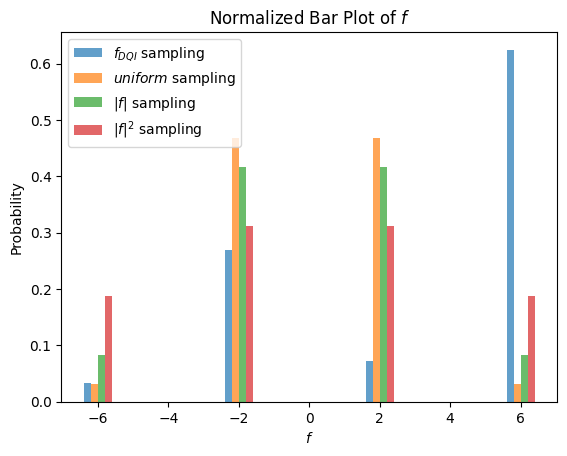

<f_uniform>: 0.0
<f_DQI>: 3.156


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Example data initialization
f_sampled = []
shots = []

# Populate f_sampled and shots based on res.parsed_counts
for sample in res.parsed_counts:
    solution = sample.state["solution"]
    f_sampled.append(((-1) ** (B @ solution + v)).sum())
    shots.append(sample.shots)
f_sampled = np.array(f_sampled)
shots = np.array(shots)

unique_f_sampled, indices = np.unique(f_sampled, return_inverse=True)
prob_f_sampled = np.array(
    [shots[indices == i].sum() for i in range(len(unique_f_sampled))]
)
prob_f_sampled = prob_f_sampled / prob_f_sampled.sum()

f_values, f_counts = np.unique(f, return_counts=True)
prob_f_uniform = np.array(f_counts) * np.array(f_values)
prob_f_uniform = f_counts / sum(f_counts)

prob_f_abs = np.array(f_counts) * np.array(np.abs(f_values))
prob_f_abs = prob_f_abs / prob_f_abs.sum()

prob_f_squared = np.array(f_counts) * np.array(f_values**2)
prob_f_squared = prob_f_squared / prob_f_squared.sum()


# Plot normalized bar plots
bar_width = 0.2
plt.bar(
    unique_f_sampled - 1.5 * bar_width,
    prob_f_sampled,
    width=bar_width,
    alpha=0.7,
    label="$f_{DQI}$ sampling",
)
plt.bar(
    f_values - 0.5 * bar_width,
    prob_f_uniform,
    width=bar_width,
    alpha=0.7,
    label="$uniform$ sampling",
)
plt.bar(
    f_values + 0.5 * bar_width,
    prob_f_abs,
    width=bar_width,
    alpha=0.7,
    label="$|f|$ sampling",
)
plt.bar(
    f_values + 1.5 * bar_width,
    prob_f_squared,
    width=bar_width,
    alpha=0.7,
    label="$|f|^2$ sampling",
)

plt.title("Normalized Bar Plot of $f$")
plt.xlabel("$f$")
plt.ylabel("Probability")
plt.legend()
plt.show()

print("<f_uniform>:", np.average(f))
print("<f_DQI>:", np.average(f_sampled, weights=shots))

## References

<a id='DQI'>[1]</a>: [Jordan, Stephen P., et al. "Optimization by Decoded Quantum Interferometry." arXiv preprint arXiv:2408.08292 (2024).](https://arxiv.org/abs/2408.08292)


<a id='Dicke'>[2]</a>: [Bärtschi, Andreas, and Stephan Eidenbenz. "Deterministic Preparation of Dicke States." In *Fundamentals of Computation Theory*, pp. 126–139. Springer International Publishing, 2019.](http://dx.doi.org/10.1007/978-3-030-25027-0_9)

<a id='SYND'>[3]</a>: ["Linear Block Codes: Encoding and Syndrome Decoding" from MIT's OpenCourseWare](https://ocw.mit.edu/courses/6-02-introduction-to-eecs-ii-digital-communication-systems-fall-2012/resources/mit6_02f12_chap06/).